# Improved Bookmark Clustering

This notebook demonstrates an improved process for clustering bookmarks, aiming for a higher silhouette score.

In [5]:
import json
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm

## Helper Functions

In [6]:
def analyze_embeddings(embeddings):
    print("Embedding analysis:")
    print(f"Shape: {embeddings.shape}")
    print(f"Mean: {np.mean(embeddings)}")
    print(f"Std: {np.std(embeddings)}")
    print(f"Min: {np.min(embeddings)}")
    print(f"Max: {np.max(embeddings)}")
    
    plt.figure(figsize=(10, 5))
    plt.hist(embeddings.flatten(), bins=50)
    plt.title("Distribution of Embedding Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

def preprocess_embeddings(embeddings):
    # Center and normalize embeddings
    embeddings_centered = embeddings - np.mean(embeddings, axis=0)
    embeddings_normalized = embeddings_centered / np.linalg.norm(embeddings_centered, axis=1, keepdims=True)
    return embeddings_normalized

def count_bookmarks(folder):
    if folder["type"] == "bookmark":
        return 1
    return sum(count_bookmarks(child) for child in folder.get("children", []))

def print_folder_structure(folder, indent=0):
    if folder["type"] == "bookmark":
        print("  " * indent + f"- {folder['name']} (Bookmark)")
    else:
        bookmark_count = sum(1 for child in folder.get("children", []) if child["type"] == "bookmark")
        subfolder_count = sum(1 for child in folder.get("children", []) if child["type"] == "folder")
        print("  " * indent + f"+ {folder['name']} ({bookmark_count} bookmarks, {subfolder_count} subfolders)")
        for child in folder.get("children", []):
            print_folder_structure(child, indent + 1)

def reduce_dimensions(embeddings, n_components=50):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    return svd.fit_transform(embeddings)

## Improved Clustering Functions

In [7]:
def optimize_hierarchical_clustering(embeddings):
    best_score = -1
    best_params = {}
    best_labels = None
    
    linkage_methods = ['ward', 'complete', 'average', 'single']
    distance_metrics = ['euclidean', 'cosine']
    
    for method in tqdm(linkage_methods, desc="Trying linkage methods"):
        for metric in distance_metrics:
            if method == 'ward' and metric != 'euclidean':
                continue  # Ward method only works with euclidean distance
            
            Z = linkage(embeddings, method=method, metric=metric)
            
            for distance_threshold in np.arange(0.5, 3.0, 0.1):
                labels = fcluster(Z, t=distance_threshold, criterion='distance')
                
                if len(set(labels)) > 1:
                    score = silhouette_score(embeddings, labels, metric='cosine')
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'method': method,
                            'metric': metric,
                            'distance_threshold': distance_threshold
                        }
                        best_labels = labels
    
    return best_score, best_params, best_labels

def optimize_kmeans(embeddings):
    best_score = -1
    best_params = {}
    best_labels = None
    
    for n_clusters in tqdm(range(2, 51), desc="Trying K-Means"):  # Try up to 50 clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        
        score = silhouette_score(embeddings, labels, metric='cosine')
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters}
            best_labels = labels
    
    return best_score, best_params, best_labels

def build_folder_structure(labels, bookmark_data):
    clusters = defaultdict(list)
    for i, label in enumerate(labels):
        clusters[label].append(bookmark_data[i])
    
    def create_folder(name, bookmarks):
        return {
            "name": name,
            "type": "folder",
            "children": [{
                "name": bookmark["title"],
                "type": "bookmark",
                "url": bookmark["url"]
            } for bookmark in bookmarks]
        }
    
    root_folder = {
        "name": "Root",
        "type": "folder",
        "children": [create_folder(f"Cluster {label}", bookmarks) for label, bookmarks in clusters.items()]
    }
    
    return root_folder

## Load Data and Perform Clustering

Embedding analysis:
Shape: (258, 768)
Mean: 0.000832342818566706
Std: 0.543851533816558
Min: -2.152575
Max: 2.205148


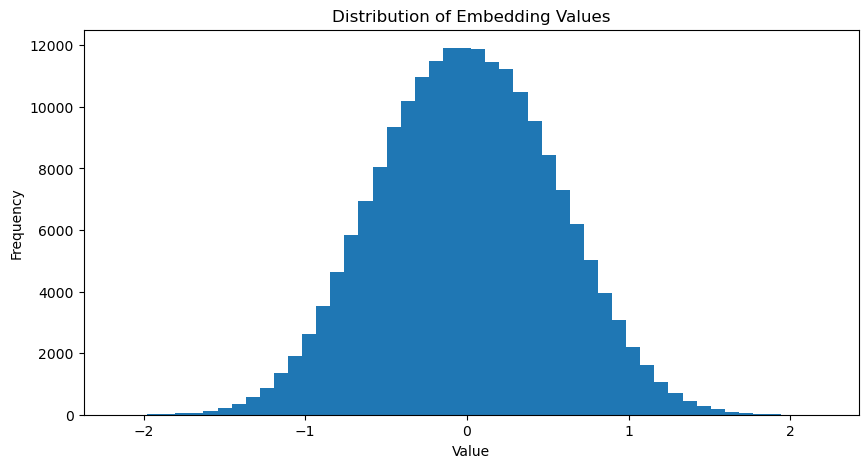


Hierarchical Clustering:


Trying linkage methods:   0%|          | 0/4 [00:00<?, ?it/s]

Best Silhouette Score: 0.2341
Best Parameters: {'method': 'ward', 'metric': 'euclidean', 'distance_threshold': 1.0999999999999999}
Number of Clusters: 72

K-Means Clustering:


Trying K-Means:   0%|          | 0/49 [00:00<?, ?it/s]

Best Silhouette Score: 0.1977
Best Parameters: {'n_clusters': 48}

Hierarchical clustering performed better. Using hierarchical clusters.

Folder Structure:
+ Root (0 bookmarks, 72 subfolders)
  + Cluster 39 (2 bookmarks, 0 subfolders)
    - Debugging - Runtime / this-firefox (Bookmark)
    - Debugging - Setup (Bookmark)
  + Cluster 46 (2 bookmarks, 0 subfolders)
    - Get Help (Bookmark)
    - Customize Firefox (Bookmark)
  + Cluster 45 (2 bookmarks, 0 subfolders)
    - Get Involved (Bookmark)
    - Volunteer Opportunities at Mozilla — Mozilla (Bookmark)
  + Cluster 10 (4 bookmarks, 0 subfolders)
    - About Us (Bookmark)
    - Operation Sea-Spray - Wikipedia (Bookmark)
    - Phoenix Program - Wikipedia (Bookmark)
    - World Bank - Wikipedia (Bookmark)
  + Cluster 31 (6 bookmarks, 0 subfolders)
    - scikit-learn-contrib/hdbscan: A high performance implementation of HDBSCAN clustering. (Bookmark)
    - Error page :( (Bookmark)
    - Learn | Pinecone (Bookmark)
    - Machine Learning 

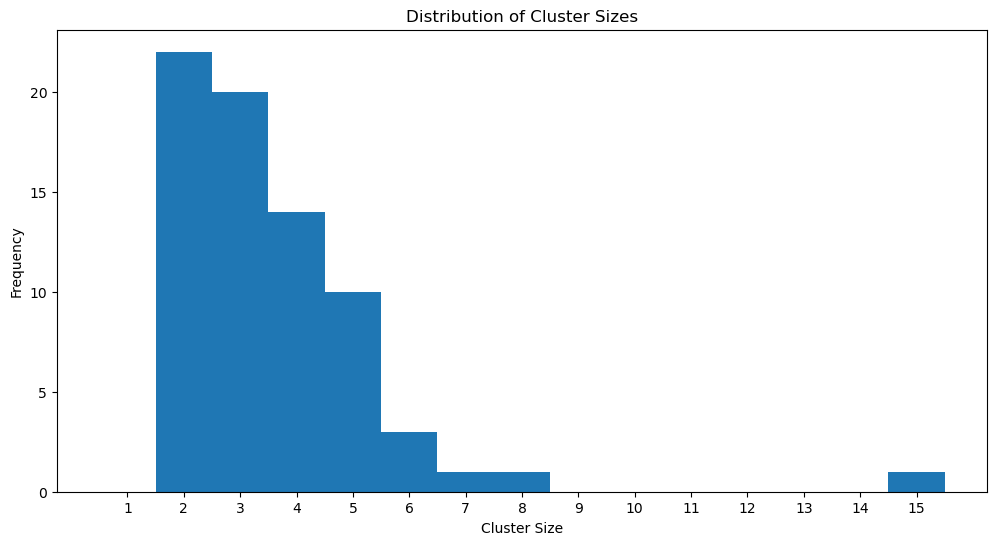


Average cluster size: 3.58
Median cluster size: 3.00
Largest cluster size: 15
Number of singleton clusters: 0


In [8]:
# Load the embedded bookmarks
with open('embedded_bookmarks.json') as f:
    data = json.load(f)

embeddings = np.array([bookmark["embedding"] for bookmark in data])
analyze_embeddings(embeddings)

embeddings_preprocessed = preprocess_embeddings(embeddings)
embeddings_reduced = reduce_dimensions(embeddings_preprocessed)

print("\nHierarchical Clustering:")
hier_score, hier_params, hier_labels = optimize_hierarchical_clustering(embeddings_reduced)
print(f"Best Silhouette Score: {hier_score:.4f}")
print(f"Best Parameters: {hier_params}")
print(f"Number of Clusters: {len(set(hier_labels))}")

print("\nK-Means Clustering:")
kmeans_score, kmeans_params, kmeans_labels = optimize_kmeans(embeddings_reduced)
print(f"Best Silhouette Score: {kmeans_score:.4f}")
print(f"Best Parameters: {kmeans_params}")

# Choose the better performing method
if kmeans_score > hier_score:
    print("\nK-Means performed better. Using K-Means clusters.")
    best_labels = kmeans_labels
else:
    print("\nHierarchical clustering performed better. Using hierarchical clusters.")
    best_labels = hier_labels

folder_structure = build_folder_structure(best_labels, data)

print("\nFolder Structure:")
print_folder_structure(folder_structure)

# Visualization of Cluster Sizes
cluster_sizes = [len(cluster["children"]) for cluster in folder_structure["children"]]

plt.figure(figsize=(12, 6))
plt.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2, 1), align='left')
plt.title("Distribution of Cluster Sizes")
plt.xlabel("Cluster Size")
plt.ylabel("Frequency")
plt.xticks(range(1, max(cluster_sizes) + 1, 1))
plt.show()

print(f"\nAverage cluster size: {np.mean(cluster_sizes):.2f}")
print(f"Median cluster size: {np.median(cluster_sizes):.2f}")
print(f"Largest cluster size: {max(cluster_sizes)}")
print(f"Number of singleton clusters: {cluster_sizes.count(1)}")

## Analysis and Conclusions

In this section, you can add your observations about the clustering results, discuss the effectiveness of the different clustering approaches, and suggest potential improvements or next steps.